In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2
import sample_data

np.random.seed(0)
N_train = 500; N_test = 100
N = N_train + N_test
train = np.arange(N_train); test = np.arange(N_test) + N_train
n_min = 25; n_max = 25

X, y = sample_data.periodic(N, n_min, n_max, t_max=2*np.pi, even=False,
                            A=1., sigma=2., w_min=0.1, w_max=1.)

/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


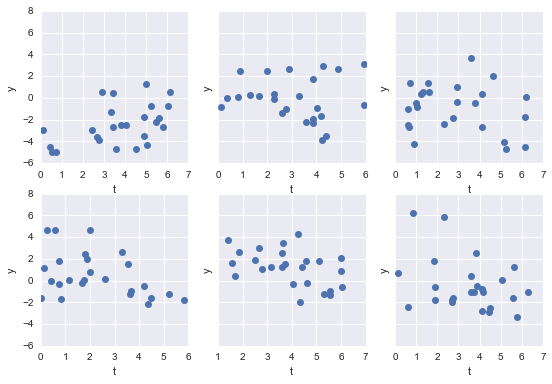

In [2]:
fig, ax = plt.subplots(2, 3, sharey=True)
for j in range(6):
#    i = np.where(y == j)[0][0]
    i = j
#    ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[i], 'o')
    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
    ax.ravel()[j].set(xlabel="t", ylabel="y")

In [3]:
import os
import tensorflow as tf
from keras import backend as K
from keras.layers import (Input, Dense, TimeDistributed, Activation, LSTM,
                          Dropout, merge, Reshape, Flatten, RepeatVector)
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ProgbarLogger, TensorBoard
from IPython.display import clear_output


lstm_size = 16
lr = 2e-3
drop_frac = 0.0
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.3)))
K.set_session(sess)
run = "{:03d}_{:1.0e}_drop{}".format(lstm_size, lr, drop_frac).replace('e-', 'm').replace('.', '')
print(run)

main_input = Input(shape=(n_max, 2))
encoding = LSTM(lstm_size, input_length=n_max, input_dim=2, return_sequences=False)(main_input)
dropout = Dropout(drop_frac)(encoding)
#aux_input = Input(shape=(n_max, 1), name='aux_input')
#tiled = RepeatVector(n_max)(dropout)
#merged = merge([aux_input, tiled], mode='concat')
#lstm_out = LSTM(lstm_size, return_sequences=True)(merged)
#output = TimeDistributed(Dense(1, activation='linear'))(lstm_out)
output = Dense(1, activation='linear')(dropout)
model = Model(input=main_input, output=output)
adam = Adam(lr=lr)
model.compile(optimizer=adam, loss='mse', metrics=[])

log_dir = os.path.expanduser('~/Dropbox/Documents/timeflow/keras2_logs/metadata_test/{}'.format(run))
!rm -rf $log_dir
#if os.path.exists(log_dir):
#    raise Exception("Log directory already exists, not overwriting")
history = model.fit(X[train], y[train], 
                     nb_epoch=10, batch_size=250, validation_split=0.2,
                     callbacks=[ProgbarLogger(), TensorBoard(log_dir=log_dir, write_graph=False)])
model.save_weights(os.path.join(log_dir, 'weights.h5'), overwrite=True)
clear_output()

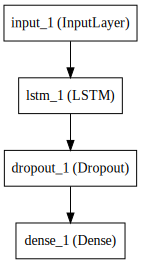

In [4]:
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

model_dot = model_to_dot(model).create(prog='dot', format='svg')
SVG(model_dot)